# Multivariate Regression

### Goal:

* To assess the characteristics of CA counties with a high percentage of residents living in low access low income areas:


In [1]:
from scipy.stats.stats import pearsonr
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split


In [7]:
df = pd.read_csv('/Users/desert/desert_workspace/desert_data/multi_fd_data.csv').set_index('County')
cols = df.columns.tolist()

def pop_proportion(s):
    proportion =  s['state_pop_ratio'] * s['food_deserts']
    return pd.Series({'fd_proportion': proportion})

df = df.merge(df.apply(pop_proportion, axis=1), left_index=True, right_index=True)
df.head()


,des_percent,pop_in_des,perc_lila,POP2010,food_deserts,n_tracts,urban_des,rural_des,n_urban,n_rural,...,opiods_rx_1000,opiods_greater_than_stateavg,MILK_PRICE10,SODA_PRICE10,MILK_SODA_PRICE10,PCH_FFR_07_12,FFR07,FFR12,pct_nonwhite,fd_proportion
County,,,,,,,,,,,,,,,,,,,,,
Alameda,0.041667,0.037134,0.018032,1510271,15,360,0.042373,0.000000,0.983333,0.016667,...,557.20,0,1.122215,1.164422,0.891575,8.902878,1112.0,1211,0.483413,0.608098
Alpine,0.000000,0.000000,0.266288,1175,0,1,0.000000,0.000000,0.000000,1.000000,...,578.68,0,1.032918,1.089488,0.877073,-50.000000,2.0,1,0.310400,0.000000
Amador,0.000000,0.000000,0.149514,38091,0,9,0.000000,0.000000,0.000000,1.000000,...,1244.76,1,1.032918,1.089488,0.877073,-5.555556,18.0,17,0.055533,0.000000
Butte,0.274510,0.268086,0.145583,220000,14,51,0.342105,0.076923,0.745098,0.254902,...,1389.20,1,0.996443,1.130546,0.815374,2.684564,149.0,153,0.096562,0.082676
Calaveras,0.000000,0.000000,0.203345,45578,0,10,0.000000,0.000000,0.200000,0.800000,...,1068.98,1,1.032918,1.089488,0.877073,-7.407407,27.0,25,0.060800,0.000000


Below creates some masks to reduce our dataset's dimensionality. We will reduce it further through feature selections methods. Although more complex techniques might yield better performing models (PCA regression, ect..), we must avoid complex transformations so our results remain easily interpretable.  

In [20]:
infx = ['std','vaccine_dx','food_dx']
qi = ['mort_30_copd', 'mort_30_hf', 'mort_30_pn', 'readm_30_copd', 'readm_30_hf', 'readm_30_pn']
health_and_access = ['PC_PHYS_R', 'DENTIST_R', 'PSYCH_R','n_hospitals','cnty_obesity_pct_adj', 'cnty_dm_pct_adj', 'cnty_inactive_pct_adj', 'ABR', 'opiods_rx_1000']
#race = ['PCT_WHITE', 'pct_nonwhite']
race = ['PCT_HSPNC', 'PCT_WHITE','PCT_BLACK', 'PCT_ASIAN', 'PCT_ISLANDER', 'PCT_MULTI', 'PCT_OTHER']
age = [ 'PCT_65OVER', 'PCT_18_64', 'PCT_UNDR18', 'PCT_UNDER5']
social = ['n_rural','total_housing_units', 'pop_in_group_housing', 'p_hs_edatt', 'SODA_PRICE10', 'FFR07', 'FFR12']
ex=['food_deserts','perc_lila','pop_LILA', 'n_tracts','urban_des','rural_des','POP2010','County','des_percent','pop_in_des']
targets = ['food_deserts','des_percent','pop_in_des', 'perc_lila']
y_var = ['perc_lila']
preds = infx+qi+health_and_access+race+age+social

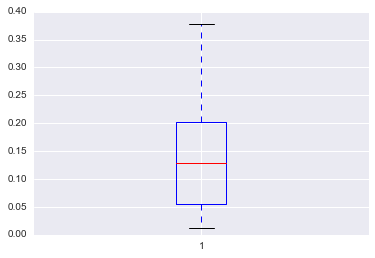

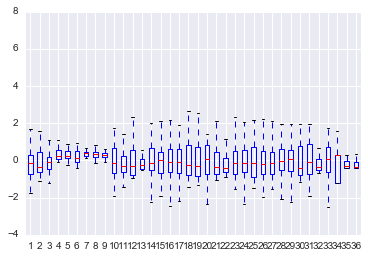

In [29]:
X=df[preds]
y = df['perc_lila'].values

def assess_vars(X, names):
    standard = StandardScaler(with_mean=True, with_std=True)
    Xs = standard.fit_transform(X)
    boxplot = plt.boxplot(Xs[:,:])
    plt.show()

plt.boxplot(y)
plt.show()
assess_vars(X, preds)

Lets plot our target variable's diistribution and gather some summary statistics of our dataset.

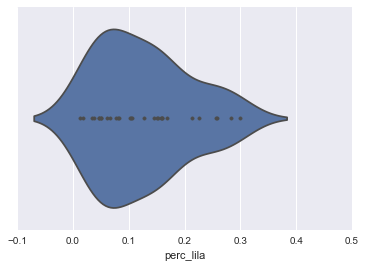

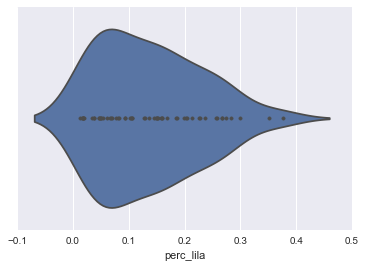

In [30]:
def RemoveOutliers(frame, m=3):
    new_data = pd.DataFrame(frame)
    clean_data = new_data[np.abs(new_data-new_data.mean())<=(m*new_data.std())]
    return clean_data.dropna(axis=0)


def standardize(feat):
    return (feat - np.mean(feat)) / np.std(feat)


g= sns.violinplot(x='perc_lila', data=RemoveOutliers(df),inner='point')
plt.show()
sns.violinplot(x='perc_lila', data=df,inner='point')
plt.show()



In [31]:
df[preds].describe()

,std,vaccine_dx,food_dx,mort_30_copd,mort_30_hf,mort_30_pn,readm_30_copd,readm_30_hf,readm_30_pn,PC_PHYS_R,...,PCT_18_64,PCT_UNDR18,PCT_UNDER5,n_rural,total_housing_units,pop_in_group_housing,p_hs_edatt,SODA_PRICE10,FFR07,FFR12
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,...,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,337.635042,34.088898,17.229751,0.070586,0.106651,0.110783,0.174683,0.194287,0.152384,2184.028777,...,0.629912,0.235006,0.062722,0.377669,0.362246,0.034383,0.816686,1.122320,450.655172,478.586207
std,193.986366,30.747443,14.077325,0.029639,0.037815,0.033007,0.070906,0.067629,0.047742,1165.616692,...,0.035356,0.044266,0.016366,0.318013,0.049207,0.043467,0.075674,0.027179,1043.425811,1115.065603
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.575833,0.138013,0.026500,0.005128,0.269528,0.005229,0.629000,1.089488,2.000000,1.000000
25%,198.891657,15.753118,10.861317,0.072250,0.111938,0.108083,0.192917,0.205100,0.160625,1430.162917,...,0.604514,0.213210,0.053228,0.127369,0.325507,0.012915,0.768000,1.089488,28.250000,25.750000
50%,309.898405,23.776988,16.205939,0.078250,0.115000,0.114929,0.201071,0.217500,0.166967,2006.619015,...,0.625133,0.233353,0.064318,0.250092,0.358493,0.020053,0.822000,1.130546,119.500000,115.500000
75%,393.942061,47.525719,20.111540,0.086750,0.124600,0.126607,0.207875,0.224938,0.170409,2930.917063,...,0.645712,0.260892,0.072078,0.627273,0.404650,0.036651,0.870750,1.130546,412.500000,387.750000
max,947.176911,143.418024,101.336877,0.103000,0.148000,0.159000,0.222000,0.250000,0.180500,6386.294000,...,0.736950,0.320967,0.094400,1.000000,0.457407,0.280241,0.949000,1.164422,7175.000000,7641.000000


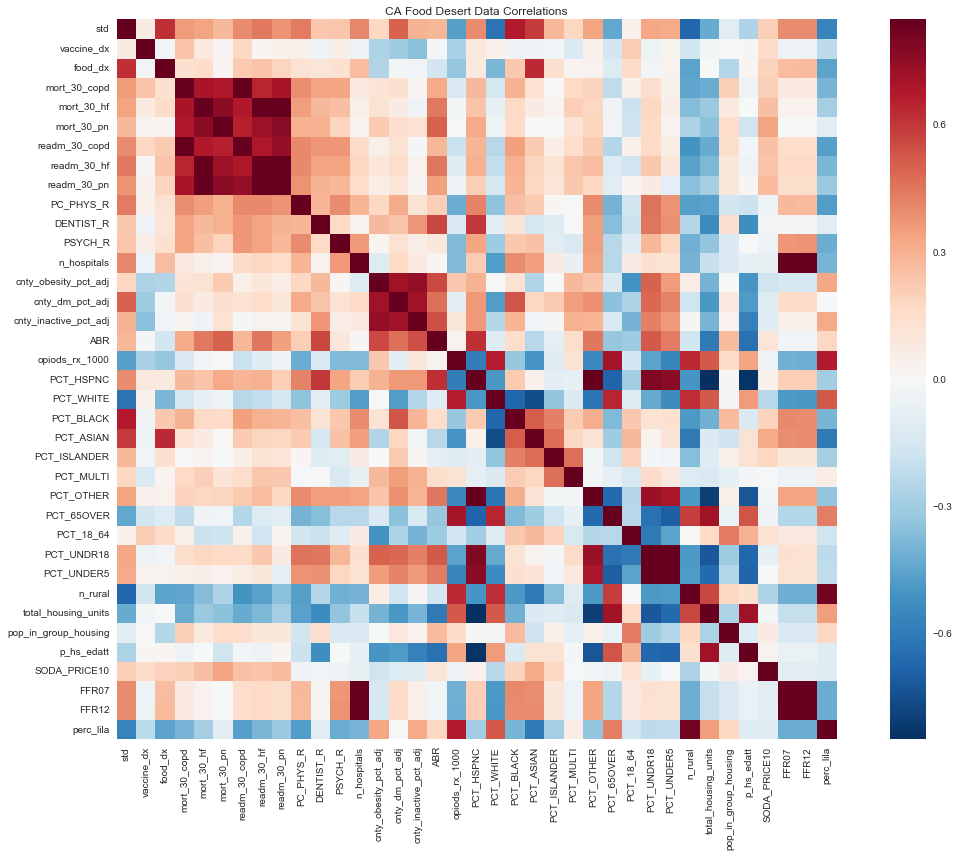

In [32]:
corrmat = df[preds+['perc_lila']].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()



###### Health Related correlations
    - Have higher rates of obesity, and inactivity
    - Have lower patient ratios for primary care physicians, psychiatrist, and dentists
    - Have lower rates of sexually transmitted disease
    - Have better hospital outcomes
    
###### Social/Demographic Related correlations
    - Tend to be older, rural, less educated, and less ethnicly diverse
    - More housing units, and more residents living in group housing
    - Have lower employment rates, education attainment
    - Have less Fast Food restraunts, and lower priced soda
    

###  Baseline OLS model

In [33]:
response = 'perc_lila'
fm = "{} ~ {} ".format(response,' + '.join(preds))
mod = sm.OLS.from_formula(fm, df.apply(standardize)).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              perc_lila   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     13.75
Date:                Wed, 10 Aug 2016   Prob (F-statistic):           1.79e-08
Time:                        13:54:49   Log-Likelihood:                 10.556
No. Observations:                  58   AIC:                             52.89
Df Residuals:                      21   BIC:                             129.1
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept              6.481e-15      0.044   1.47e-13      1.000        -0.092     0.092
std                      -0.3214      0.145     -2.211      0.038        -0.624    -0.019
vaccine_dx                0.0370      0.071      0.522      0.607        -0.110     0.184
food_dx                   0.2745      0.118      2.318      0.031         0.028     0.521
mort_30_copd             -0.2985      0.318     -0.939      0.358        -0.959     0.362
mort_30_hf                0.4612      0.323      1.426      0.169        -0.212     1.134
mort_30_pn                0.1194      0.110      1.090      0.288        -0.109     0.347
readm_30_copd             0.0761      0.282      0.270      0.790        -0.510     0.662
readm_30_hf              -0.8709      0.360     -2.418      0.025        -1.620    -0.122
readm_30_pn               0.3690      0.202      1.831      0.081        -0.050     0.788
PC_PHYS_R                 0.0319      0.076      0.417      0.681        -0.127     0.191
DENTIST_R                -0.2512      0.113     -2.217      0.038        -0.487    -0.016
PSYCH_R                   0.1361      0.081      1.677      0.108        -0.033     0.305
n_hospitals              -0.1077      0.363     -0.297      0.770        -0.863     0.648
cnty_obesity_pct_adj     -0.0216      0.138     -0.156      0.877        -0.309     0.266
cnty_dm_pct_adj          -0.1301      0.128     -1.014      0.322        -0.397     0.137
cnty_inactive_pct_adj     0.3054      0.132      2.310      0.031         0.030     0.580
ABR                       0.2133      0.146      1.460      0.159        -0.091     0.517
opiods_rx_1000            0.2918      0.153      1.909      0.070        -0.026     0.610
PCT_HSPNC                 0.0065      0.280      0.023      0.982        -0.577     0.590
PCT_WHITE                 0.2273      0.316      0.719      0.480        -0.430     0.885
PCT_BLACK                 0.2018      0.108      1.873      0.075        -0.022     0.426
PCT_ASIAN                -0.0359      0.217     -0.165      0.870        -0.488     0.416
PCT_ISLANDER              0.0494      0.080      0.616      0.545        -0.117     0.216
PCT_MULTI                 0.0991      0.080      1.232      0.232        -0.068     0.266
PCT_OTHER                -0.1708      0.218     -0.784      0.442        -0.624     0.282
PCT_65OVER                4.1206      3.924      1.050      0.306        -4.039    12.280
PCT_18_64                 4.0535      3.788      1.070      0.297        -3.823    11.930
PCT_UNDR18                5.2863      4.745      1.114      0.278        -4.582    15.154
PCT_UNDER5                0.3993      0.305      1.308      0.205        -0.235     1.034
n_rural                   0.4833      0.160      3.024      0.006         0.151     0.816
total_housing_units    


### Important Statsmodels summary Outputs for Multivariate Regression
Looking for a high R2, F-Statistic, low Prop(F-Statistic), low pvalues, low Condition No, low RSE. 

##### Things to note when adding new predictors:
* A low pvalue and a t-value far from zero indicates a strong predictor.   
* whether the addition of the variable resulted in all predictors and intercept have similar coefs
* whether values of R2 and adj-R2 are similar to the previous model when adding/removing predictors
* changes in magnitude and direction of existing coefs
* decreases in the F-statistic - predictor did not benefit model
* increases in RSE
* Condition No reflect the level of multicollinearity. The higher the Condition No, the more unstable the results.

Our 'kitchen sink' model above containing all predictors is extremely unreliable. The high Condition No. shows there is a high amount of multicolliearity. Lets assess our variables with heatmap to see how they relate, then reduce our feature space.

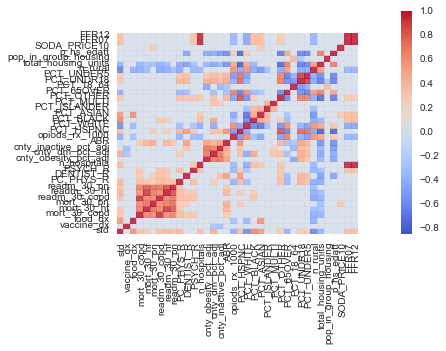

In [34]:

def visualize_feature_relationships(data, corr_cut_off = 0.0):
    import matplotlib.cm as cm
    variables = data.columns.tolist()
    mat = np.corrcoef(data, rowvar=0)
    mat[np.where(np.abs(mat)<corr_cut_off)] = 0.0
    heatmap = plt.pcolor(mat, cmap=cm.coolwarm, alpha=0.8)
    heatmap.axes.set_frame_on(False)
    heatmap.axes.set_yticks(np.arange(mat.shape[0]) + 0.75, minor=False)
    heatmap.axes.set_xticks(np.arange(mat.shape[1]) + 0.75, minor=False)
    heatmap.axes.set_xticklabels(variables, minor=False)
    plt.xticks(rotation=90)
    heatmap.axes.set_yticklabels(variables, minor=False)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', left = 'off', right = 'off')
    plt.colorbar()
    plt.show()

visualize_feature_relationships(df[preds].apply(standardize), corr_cut_off=0.3)


Removed predictors (in order): 

FFR12
FFR07
readm_30_copd
readm_30_hf
PCT_UNDER5
PCT_OTHER
total_housing_units
readm_30_pn
p_hs_edatt
PCT_UNDR18
mort_30_pn
PCT_ASIAN
cnty_inactive_pct_adj
cnty_dm_pct_adj
PCT_65OVER
mort_30_hf


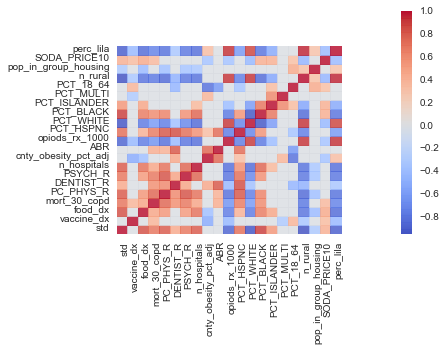

In [35]:
def remove_high_corr(corr_dataframe, thresh = 0.9):
    abs_corr = np.abs(corr_dataframe).as_matrix() 
    col_names = list(corr_dataframe.columns)
    np.fill_diagonal(abs_corr, 0)
    print "Removed predictors (in order): \n"
    while np.max(abs_corr) >= thresh:
        i, j = np.unravel_index(abs_corr.argmax(), abs_corr.shape)
        rdx = which_to_remove(i, j, abs_corr)
        print col_names.pop(rdx)
        abs_corr = np.delete(abs_corr, rdx, 0)
        abs_corr = np.delete(abs_corr, rdx, 1)
    return col_names

def which_to_remove(i, j, abs_corr):
    '''compare two predictors and remove the one with higher abs correlation with other predictors'''
    i_absmean = np.mean(abs_corr[i, np.where(abs_corr[i,:] == 0)])
    j_absmean = np.mean(abs_corr[j, np.where(abs_corr[j,:] == 0)])
    return i if i_absmean > j_absmean else j


col_remained = remove_high_corr(df[preds].apply(standardize).corr(), .7)
data=df[col_remained+['perc_lila']]
corr_dataframe = data.corr()
visualize_feature_relationships(corr_dataframe, corr_cut_off=0.3)

#### Univariate Feature Selection
Another option for reducing features is to perform statistical analysis on each predictor and the target variable. Scikitlearn's f_regression looks at each predictor variable independently and returns F scores and p-values for each feature. Features that are useful in predicting y will havelarge f scores and p values < 0.05.

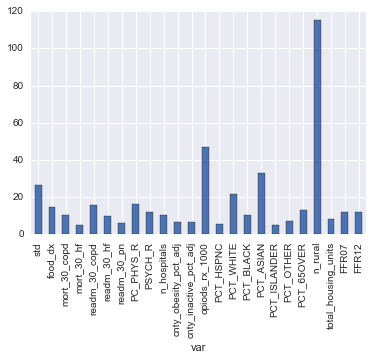

In [36]:
from sklearn.feature_selection import f_regression
fval, pval = (f_regression(df[preds].values, df['perc_lila']))
feats = pd.DataFrame(fval, columns=['fval'])
feats['pval'] = pval
feats['var'] = preds
feats = feats[feats['pval']<0.05]
feats= feats.set_index('var')
feats['fval'].plot(kind='bar')

#### Assessing standardized coefficients
Another way to quantify features influence on the target is through standardized coefficients. Putting all variables on the same scale allows us to compare our predictors effect on the target. 

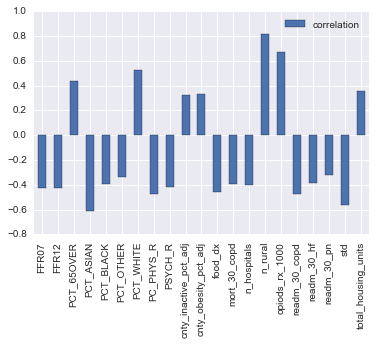

In [37]:

def covariance(variable_1, variable_2, bias=0):
    observations = float(len(variable_1))
    return np.sum((variable_1 - np.mean(variable_1)) * (variable_2 - np.mean(variable_2)))/(observations-min(bias,1))

def standardize(variable):
    return (variable - np.mean(variable)) / np.std(variable)

def correlation(var1,var2,bias=0):
    return covariance(standardize(var1), standardize(var2),bias)

def assess_feats_correlation(predictor_vars, target_var, dataset):
    feats_corr = {}
    for feature in predictor_vars:
        feats_corr[feature] = (target, correlation(dataset[feature], dataset[target_var]))
    feats_corr = pd.DataFrame(feats_corr).T
    feats_corr.columns = ['target_var', 'correlation']
    feats_corr['correlation'] = feats_corr['correlation'].astype(float)
    return feats_corr

target= 'perc_lila'
corr=assess_feats_correlation(preds, target, standardize(df))
corr[abs(corr['correlation']) > .3].plot(kind='bar')
uni_cor = list(corr.index)


Lets fit our model again but this time excluding collinear variables.

In [38]:
fm = "{} ~ {} ".format(response,' + '.join(col_remained))
mod = sm.OLS.from_formula(fm, RemoveOutliers(standardize(df))).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              perc_lila   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     13.52
Date:                Wed, 10 Aug 2016   Prob (F-statistic):           0.000185
Time:                        13:54:54   Log-Likelihood:                 12.842
No. Observations:                  30   AIC:                             16.32
Df Residuals:                       9   BIC:                             45.74
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept               -0.2529      0.110     -2.303      0.047        -0.501    -0.005
std                     -0.1756      0.198     -0.887      0.398        -0.623     0.272
vaccine_dx               0.0024      0.162      0.015      0.988        -0.364     0.369
food_dx                  0.1732      0.238      0.729      0.485        -0.364     0.711
mort_30_copd             0.3521      0.166      2.127      0.062        -0.022     0.727
PC_PHYS_R               -0.1131      0.115     -0.986      0.350        -0.372     0.146
DENTIST_R               -0.1492      0.129     -1.160      0.276        -0.440     0.142
PSYCH_R                  0.1062      0.136      0.781      0.455        -0.201     0.414
n_hospitals              0.0581      0.228      0.255      0.805        -0.458     0.574
cnty_obesity_pct_adj     0.0707      0.121      0.585      0.573        -0.202     0.344
ABR                      0.5037      0.172      2.926      0.017         0.114     0.893
opiods_rx_1000           0.2394      0.191      1.254      0.241        -0.193     0.671
PCT_HSPNC                0.0601      0.201      0.298      0.772        -0.396     0.516
PCT_WHITE                0.1098      0.210      0.522      0.614        -0.366     0.585
PCT_BLACK                0.1538      0.167      0.921      0.381        -0.224     0.532
PCT_ISLANDER            -0.0442      0.149     -0.296      0.774        -0.381     0.293
PCT_MULTI                0.0902      0.098      0.918      0.382        -0.132     0.312
PCT_18_64                0.2487      0.135      1.847      0.098        -0.056     0.553
n_rural                  0.6979      0.193      3.618      0.006         0.262     1.134
pop_in_group_housing    -0.1419      0.241     -0.588      0.571        -0.688     0.404
SODA_PRICE10             0.0224      0.077      0.290      0.778        -0.152     0.197
==============================================================================
Omnibus:                        0.899   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.638   Jarque-Bera (JB):                0.429
Skew:                           0.292   Prob(JB):                        0.807
Kurtosis:                       3.043   Cond. No.                         14.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see some improvement but our model is still far from perfect. Lets try Lasso regression to reduce feaures further.

In [39]:
def lasso_coefs(fml, data):
    mat = []
    alphas = np.arange(0, 0.26, 0.05)
    for alpha in alphas:
        mod = sm.OLS.from_formula(fml, data)
        rslt = mod.fit_regularized(alpha=alpha)
        mat.append(rslt.params)
    mat = pd.DataFrame(mat, index=[str(x) for x in alphas])
    return mat.T
all_fm = "{} ~ {} ".format(response,' + '.join(preds))
std_df = RemoveOutliers(df)
std_df = standardize(df)
lasso_coefs(fm, std_df)

,0.0,0.05,0.1,0.15,0.2,0.25
Intercept,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,-0.415392,-0.089543,-0.025910,0.000000,0.000000,0.000000
vaccine_dx,0.028608,0.000000,0.000000,0.000000,0.000000,0.000000
food_dx,0.187934,0.000000,0.000000,0.000000,0.000000,0.000000
mort_30_copd,-0.173061,-0.088669,-0.033217,0.000000,0.000000,0.000000
PC_PHYS_R,-0.056403,-0.088990,-0.071302,-0.032625,0.000000,0.000000
DENTIST_R,-0.060948,0.000000,0.000000,0.000000,0.000000,0.000000
PSYCH_R,-0.057743,-0.013042,0.000000,0.000000,0.000000,0.000000
n_hospitals,0.028358,0.000000,0.000000,0.000000,0.000000,0.000000
cnty_obesity_pct_adj,0.252031,0.143258,0.104480,0.074119,0.049142,0.027008


In [40]:
X = df[col_remained]#pairs[p_cols[1:]].values
y = df['perc_lila']
#y = RemoveOutliers(standardize(df['perc_lila']))

In [41]:
from sklearn.cross_validation import cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import Lasso, RandomizedLasso, LassoCV
lasso = Lasso(alpha=1.0, normalize=True, max_iter=10**5)
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import expon
from sklearn.preprocessing import PolynomialFeatures
np.random.seed(101)

cv_iterator = KFold(n=len(X), n_folds=10, shuffle=True,random_state=101)
edges = np.histogram(y, bins=5)[1]
binning = np.digitize(y, edges)

stratified_cv_iterator = StratifiedKFold(binning, n_folds=10,shuffle=True, random_state=101)

search_func=RandomizedSearchCV(
    estimator=lasso, n_jobs=1, iid=False, refit=True, n_iter=15,
    param_distributions={'alpha':np.logspace(-5,2,100)},
    scoring='mean_squared_error', cv=stratified_cv_iterator)

second_order=PolynomialFeatures(degree=2, interaction_only=False)


search_func.fit(X, y)
print ('Best alpha: %0.5f' % search_func.best_params_['alpha'])
print ('Best CV mean squared error: %0.3f' % np.abs(search_func.best_score_))


/Users/desert/anaconda/envs/linreg/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


Best alpha: 0.00006
Best CV mean squared error: 0.003


In [42]:
# print 'Deg. Coefficient'
mask = pd.DataFrame((np.r_[lasso_fit.intercept_, lasso_fit.coef_])) > 0
mask = mask[0].values


NameError: name 'lasso_fit' is not defined

In [ ]:
las_f = list(X.columns[mask])

fm = "{} ~ {} ".format(response,' + '.join(las_f))
lasso_model = sm.OLS.from_formula(fm, df.apply(standardize)).fit()
lasso_model.summary()

In [43]:
las_f = ['cnty_obesity_pct_adj', 'opiods_rx_1000', 'n_rural']

fm = "{} ~ {} ".format(response,' + '.join(las_f))
lasso_model = sm.OLS.from_formula(fm, df.apply(standardize)).fit()
lasso_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              perc_lila   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     60.18
Date:                Wed, 10 Aug 2016   Prob (F-statistic):           3.15e-17
Time:                        13:54:57   Log-Likelihood:                -39.708
No. Observations:                  58   AIC:                             87.42
Df Residuals:                      54   BIC:                             95.66
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept             -3.92e-16      0.065     -6e-15      1.000        -0.131     0.131
cnty_obesity_pct_adj     0.2468      0.068      3.653      0.001         0.111     0.382
opiods_rx_1000           0.1794      0.087      2.058      0.044         0.005     0.354
n_rural                  0.6917      0.085      8.144      0.000         0.521     0.862
==============================================================================
Omnibus:                        2.702   Durbin-Watson:                   2.204
Prob(Omnibus):                  0.259   Jarque-Bera (JB):                2.121
Skew:                           0.106   Prob(JB):                        0.346
Kurtosis:                       3.913   Cond. No.                         2.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

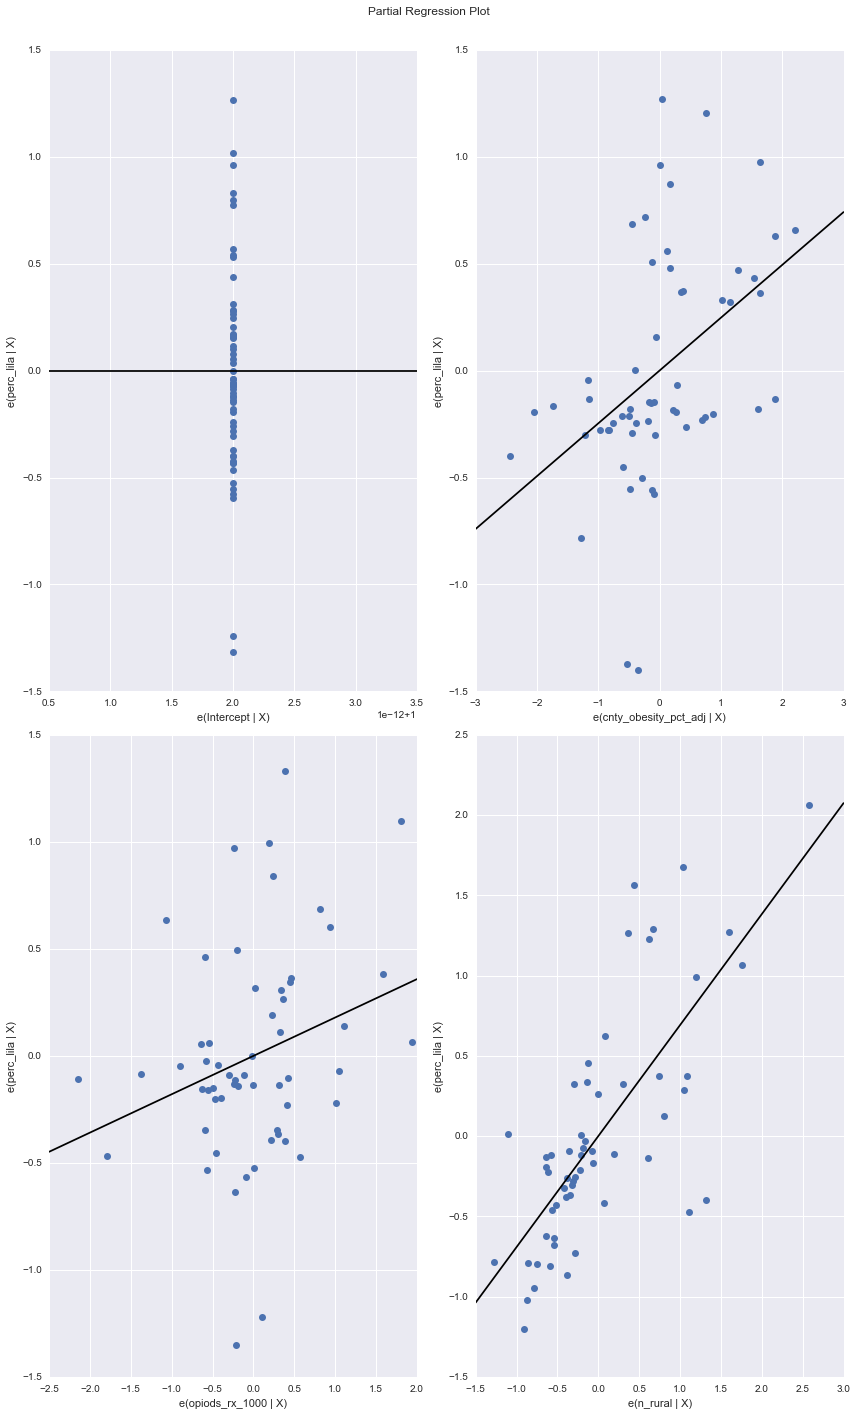

In [44]:
fig = plt.figure(figsize=(12,20))
fig = sm.graphics.plot_partregress_grid(lasso_model, fig=fig)


### Forward Feature Selection
Using lasso to select features has helped us make a reliable model. Now lets try another method reffered to as sequential foward selection. In this method we sequentially add predictors to our model attempting to maximize a specified measure. Below we attempt to maximize R-squared, the amount of variance our model is able to explain.

In [48]:
def forward_feature_selection(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,' + '.join(selected))
    model = smf.ols(formula, data).fit()
    print formula
    return model

std_df= RemoveOutliers(standardize(df[col_remained+['perc_lila']]))
lr_model=forward_feature_selection(std_df, 'perc_lila')

perc_lila ~ n_rural + ABR + PC_PHYS_R + mort_30_copd + std + cnty_obesity_pct_adj + DENTIST_R + PCT_18_64 + opiods_rx_1000 + SODA_PRICE10 + 1


In [49]:
lr_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              perc_lila   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     26.71
Date:                Wed, 10 Aug 2016   Prob (F-statistic):           1.74e-13
Time:                        13:55:30   Log-Likelihood:                -16.906
No. Observations:                  46   AIC:                             55.81
Df Residuals:                      35   BIC:                             75.93
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept               -0.0508      0.062     -0.820      0.418        -0.177     0.075
n_rural                  0.4798      0.101      4.727      0.000         0.274     0.686
ABR                      0.4040      0.095      4.262      0.000         0.212     0.596
PC_PHYS_R               -0.0576      0.085     -0.675      0.504        -0.231     0.116
mort_30_copd            -0.1632      0.075     -2.162      0.038        -0.316    -0.010
std                     -0.3330      0.104     -3.201      0.003        -0.544    -0.122
cnty_obesity_pct_adj     0.3498      0.103      3.387      0.002         0.140     0.559
DENTIST_R               -0.2439      0.102     -2.383      0.023        -0.452    -0.036
PCT_18_64                0.1784      0.096      1.853      0.072        -0.017     0.374
opiods_rx_1000           0.1419      0.087      1.640      0.110        -0.034     0.318
SODA_PRICE10             0.0737      0.066      1.115      0.272        -0.060     0.208
==============================================================================
Omnibus:                       10.221   Durbin-Watson:                   2.324
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               11.439
Skew:                          -0.779   Prob(JB):                      0.00328
Kurtosis:                       4.882   Cond. No.                         4.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Partial regression plots: assesing feature effects on target variable

A subplot is created for each explanatory variable contained in our model.The partial regression plot shows the relationship between perc_lila and the given explanatory variable after removing the effect of all other explanatory variables. (http://statsmodels.sourceforge.net/devel/_modules/statsmodels/graphics/regressionplots.html)

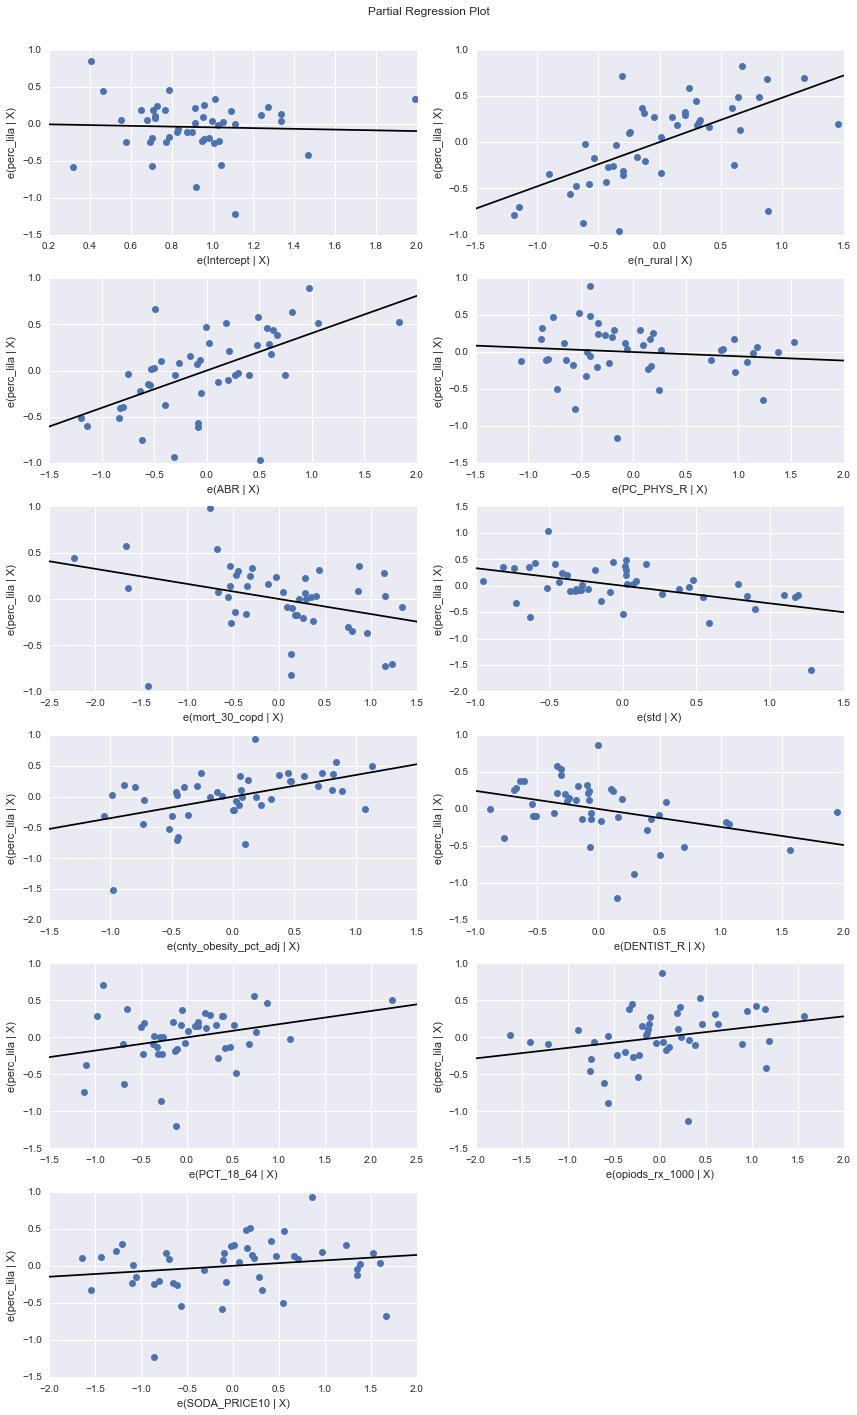

In [50]:
fig = plt.figure(figsize=(12, 20))
fig = sm.graphics.plot_partregress_grid(lr_model, fig=fig)


The plots below identify the observations that have the most influence and leverage. 

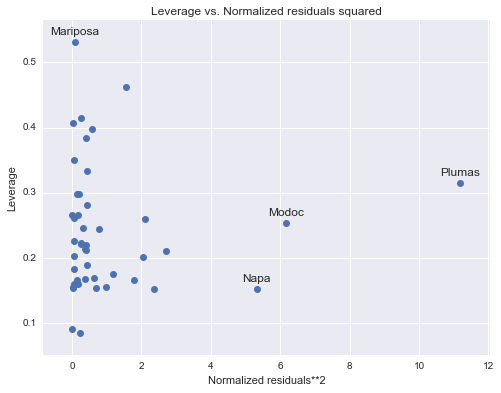

In [51]:
fig, ax = plt.subplots(figsize=(8,6))
fig = sm.graphics.plot_leverage_resid2(lr_model, ax=ax)


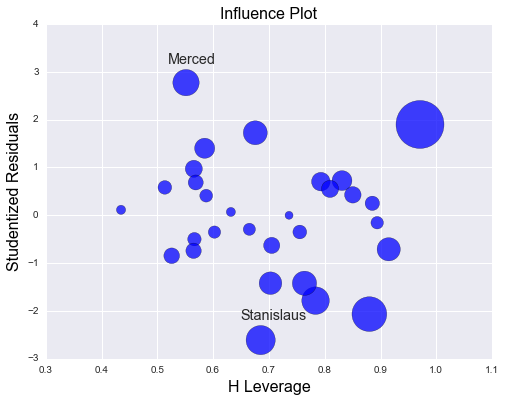

In [52]:
fig, ax = plt.subplots(figsize=(8,6))
fig = sm.graphics.influence_plot(mod, ax=ax)


## Model specific approach - Random Forest Regression
Random forests determine feature importance through the information gain provided by variables. When using this model to assess feature importance, we must look at the results cautiously. This is because it eliminate variables that are colinnear, which may lead us to misinterpret the true value of features that recieve lower scores. Below shows the feature importances of predictors using this model specific approach.


Random Forest: Performance metrics, feat_importance, and features assessed

[ 0.01898286  0.0109147   0.00681283  0.0030592   0.00244741  0.00454061
  0.00983328  0.00291407  0.00708187  0.0169088   0.0075422   0.03162774
  0.00311961  0.01210652  0.00214182  0.0489988   0.0148767   0.03266605
  0.00333831  0.00446353  0.02044908  0.03591786  0.00864852  0.00632287
  0.00571032  0.00325256  0.00964105  0.0088053   0.00428987  0.54276596
  0.00699354  0.00409556  0.00400096  0.00333109  0.05254177  0.03885678]
['std', 'vaccine_dx', 'food_dx', 'mort_30_copd', 'mort_30_hf', 'mort_30_pn', 'readm_30_copd', 'readm_30_hf', 'readm_30_pn', 'PC_PHYS_R', 'DENTIST_R', 'PSYCH_R', 'n_hospitals', 'cnty_obesity_pct_adj', 'cnty_dm_pct_adj', 'cnty_inactive_pct_adj', 'ABR', 'opiods_rx_1000', 'PCT_HSPNC', 'PCT_WHITE', 'PCT_BLACK', 'PCT_ASIAN', 'PCT_ISLANDER', 'PCT_MULTI', 'PCT_OTHER', 'PCT_65OVER', 'PCT_18_64', 'PCT_UNDR18', 'PCT_UNDER5', 'n_rural', 'total_housing_units', 'pop_in_group_housing', 'p_hs_ed

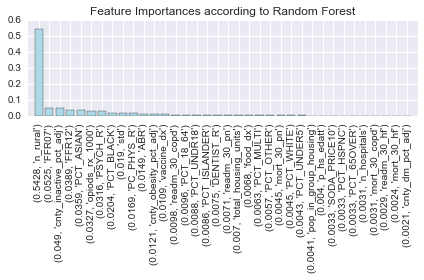

In [56]:
from sklearn.ensemble import RandomForestRegressor

def try_forest(X_train, y_train):
    '''
    Does not accept datetimes as features, must convert date to numeric or string and drop date feature prior to using.
    :param X_train:
    :param y_train:
    :return: Random Forest classifier, feature importance values, and features indices
    '''
    print '='*100
    print "\nRandom Forest: Performance metrics, feat_importance, and features assessed\n"
    forest = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
    forest.fit(X_train, y_train)
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    print importances
    print list(X_train.columns)
    X_selected = forest.transform(X_train, threshold=0.10)
    return forest, importances, indices,X_selected


def sort_features(forest):
    '''
    :param forest: a random forest classifier
    :return: sorted list containing tuples of feature names and the importances according to the classifier (rounded to 4 decimals)
    '''
    feat_labels=X.columns
    print '='*100
    print "\nClarifying Feat_importance: Features sorted by their Importance according to Random Forest:\n"
    print sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), feat_labels), reverse=True)
    f_rank = []
    for f in sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), feat_labels), reverse=True):
        f_rank += [f]
    return f_rank


def plot_importances(X_train, importances, f_rank):
    '''
    :param X_train: Dataframe containing predictor variables of training set
    :param importances: List of feature importance, obtained from try_forest
    :param f_rank: Feature ranking, obtained from sort_features()
    :return: None, plot saved as 'Forest_feature_importances.png'
    '''
    plt.title('Feature Importances according to Random Forest')
    plt.bar(range(X_train.shape[1]), importances[indices], color='lightblue', align='center')
    plt.xticks(range(X_train.shape[1]), f_rank, rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.tight_layout()
    plt.savefig('Forest_feature_importances.png')
    plt.show(1)


feat_labels=df[preds+['perc_lila']].columns.tolist()
forest, importance, indices,X_selected = try_forest(df[preds], df[target])
f_rank = sort_features(forest)
plot_importances(df[preds], importance, f_rank)


In [57]:
from sklearn.linear_model import Ridge, Lasso, RandomizedLasso, LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

np.random.seed(0)
ranks = {}
 
def rank_to_dict(ranks, predictors, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(predictors, ranks ))
predictors = preds
Y = df['perc_lila']
X = df[preds]#.values

lr = LinearRegression(normalize=True)
lr.fit(X, Y)
ranks["Linear reg"] = rank_to_dict(np.abs(lr.coef_), predictors)
 
ridge = Ridge(alpha=7)
ridge.fit(X, Y)
ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), predictors)
 
lasso = Lasso(alpha=.01)
lasso.fit(X, Y)
ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), predictors)
 
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["Stability"] = rank_to_dict(np.abs(rlasso.scores_), predictors)
 
rfe = RFE(lr, n_features_to_select=4)
rfe.fit(X,Y)
ranks["RFE"] = rank_to_dict(map(float, rfe.ranking_), predictors, order=-1)
 
rf = RandomForestRegressor()
rf.fit(X,Y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, predictors)
 
f, pval  = f_regression(X, Y, center=True)
ranks["Corr."] = rank_to_dict(f, predictors)

methods = sorted(ranks.keys())
feature_df = pd.DataFrame(ranks)
feature_df['mean'] = feature_df.mean(axis=1)
feature_df

,Corr.,Lasso,Linear reg,RF,RFE,Ridge,Stability,mean
ABR,0.02,0.00,0.01,0.03,0.72,0.31,0.0,0.155714
DENTIST_R,0.00,0.00,0.00,0.02,0.06,0.00,0.0,0.011429
FFR07,0.11,0.13,0.00,0.12,0.25,0.01,0.0,0.088571
FFR12,0.11,0.09,0.00,0.00,0.22,0.01,0.0,0.061429
PCT_18_64,0.01,0.00,0.96,0.01,0.75,0.05,0.0,0.254286
PCT_65OVER,0.11,0.00,0.95,0.00,0.59,0.02,0.0,0.238571
PCT_ASIAN,0.29,0.00,0.00,0.03,0.38,0.12,0.0,0.117143
PCT_BLACK,0.09,0.00,0.05,0.08,0.44,0.01,0.0,0.095714
PCT_HSPNC,0.05,0.00,0.00,0.00,0.53,0.22,0.0,0.114286
PCT_ISLANDER,0.04,0.00,0.11,0.03,0.31,0.01,0.0,0.071429
